In [17]:
"""
You need to run this cell for the code in following cells to work.
"""

# Enable module reloading
%load_ext autoreload
%autoreload 2

# Enable interactive plots
%matplotlib notebook

%load_ext tensorboard
%tensorboard --logdir logs --bind_all

import sys
sys.path.append('..')

import tensorflow.keras as keras

import week_8.backstage.plots as plots
import week_8.backstage.data as data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Week 8

__Goals for this week__

We will discuss recurrent neural networks in this lab. They are useful for processing sequence data, such as sentences, time series, etc. We will also talk about word representations for natural language processing.

__Feedback__

This lab is a work in progress. If you notice a mistake, notify us or you can even make a pull request. Also please fill the [questionnaire](https://forms.gle/r27nBAvnMC7jbjJ58) after you finish this lab to give us feedback.


## Recurrent Neural Networks

_Recurrent neural networks_ (RNN) are the last major neural architecture we will talk about during our labs. They are used to process sequence data. One-dimensional CNNs can also be used for sequence processing, however, RNNs should be better at modeling long-term dependencies between individual inputs. RNNs are also more versatile for sequence data, e.g. they can be used for tasks that expect a sequence as an output, or that expect a separate label for each input.

_Recurrent cell_ lies at the heart of RNNs. Cell is the basic operation that is done as we process one step from a series of $N$ inputs $\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N$. For step $i$ the cell looks like this:

<img src="images/cell.svg" alt="Recurrent cell" style="width: 20%;"/>
   
- $\mathbf{x}_i$ is $i$-th input
- $\mathbf{y}_i$ is $i$-th output
- $\mathbf{s}_i$ is the state of cell for $i$-th step
   
All of these quantities are vectors. As the figure above illustrates, at each step the cell depends on two inputs - the input for the step itself and the state of the cell from previous step. Because the cell "sees" the state from previous steps, the layer can process the current step while using the knowledge about all the previous steps.

We can imagine the recurrent layer as a series of cell operations:

<img src="images/rnn.svg" alt="Recurrent layer" style="width: 50%;"/>
   
Note that when we follow the flow of computation leading to output $\mathbf{y}_i$, we can see that it depends on all the previous inputs $\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_i$. It also depends on the initial state $\mathbf{s}_0$, which is usually a trainable parameter vector of the model.

### Recurrent cell variants

Multiple variants of recurrent cells exist, e.g. this is the definition of _Ellman cell:_

$
\mathbf{h}_i = \sigma(\mathbf{W}_{in}\mathbf{x}_i + \mathbf{W}_{hid}\mathbf{s}_{i-1} + \mathbf{b}_{hid}) \\
\mathbf{y}_i = \sigma(\mathbf{W}_{out}\mathbf{h}_i + \mathbf{b}_{out})  \\
\mathbf{s}_i = \mathbf{h}_i \\
$

The definition of $\mathbf{h}_i$ and $\mathbf{y}_i$ is very similar to MLP, the only difference is that $\mathbf{h}_i$ also depends on the state from previous step cell. In this case the state $\mathbf{s}_i$ is simply the value of hidden layer $\mathbf{h}_i$ within the cell. Note that the same parameters (weights and biases) are used for each step. The computation done by a cell is the same for each step, only the inputs of the cell ($\mathbf{x}_i$ and $\mathbf{s}_{i-1}$) differ.

Simple cells like these do not perform very well. The information is being transformed by matrix multiplication each time step. This tends to dilute the information and the network "forgets" about what it has seen in the past. This limits the use of simple recurrent cells only for relatively short sequences. Simple cells are also quite unstable to train and suffer from so called _exploding / vanishing gradient_ problem.

Instead of these simple cells we usually use more complex cells that were developed to address the issues we mentioned. Most common of these cells are _LSTM_ and _GRU_ cells. Check the further reading section if you are interested in why they tend to work better than vanilla recurrent cells or how do they look like.

### Training

The operations used for RNN are very similar to MLP operations. We use matrix multiplication, addition, activation functions and that is basically all there is to it. The training routine is therefore also quite similar to MLP. Again, so in previous architectures, we use _stochastic gradient descent_ to calculate the derivatives of the loss function w.r.t. each parameter.

### Recurrent architectures

There are multiple ways of using recurrent layers depending on the nature of the task we want to solve. In all the following examples the recurrent layer is the same, we only work differently with the inputs and outputs of this layer to get it to do what we want.

#### Many to one

<img src="images/manyone.svg" alt="Many to one" style="width: 40%;"/>

We feed the recurrent layer until we process the whole input. Then we use the result of this pass to get a single result. We use this type of RNN to do:

- Sequence classification - We want to assign a label to a sequence (i.e. text classification, event detection).
- Prediction - We want to predict following values in a time series.

During the computation we can either:

- Discard all the outputs, but the last $\mathbf{y}_N$. Then we use only this output.
- Pool all the outputs using mean-pooling (or max-pooling) of all the outputs $\mathbf{y}_i$.

#### One to many

<img src="images/onemany.svg" alt="One to many" style="width: 40%;"/>

We feed the recurrent layer with one value and we expect it to produce multiple values. We use this type for:

- Generation tasks - We want to generate a series of values based on a prompt (e.g. image captioning, music generation).

During all the steps the cell expects an input $\mathbf{x}_{i>1}$, that is how it is defined. We can either use the same input each step, or we can feed the layer with the output from previous step $\mathbf{y}_{i-1}$.

#### Many to many

<img src="images/manymany.svg" alt="Many to many" style="width: 40%;"/>

We feed the recurrent layer with multiple values and we expect an output for each of them. We use this type for:

- Input tagging - We want to assign each input into a class (e.g. part-of-speech tagging, event scope detection).

#### Sequence to sequence

<img src="images/seqseq.svg" alt="Sequence to sequence" style="width: 70%;"/>

We feed the recurrent layer a series of inputs and we expect a series as an output. We use thys type for:

- Multi-hop prediction - We want to generate multiple values as a prediction.

### Advanced recurrent architectures

The architecture mentioned above show how can a single recurrent layer be used. In this section we show some examples of how to combine multiple layers for various use-cases.

#### Bi-directional recurrent network

<img src="images/bidirectional.svg" alt="Bi-directional" style="width: 70%;"/>

We can combine two recurrent layers, one that processes the data from start to end, while the other goes backwards from end to start. We simply combine the outputs of these two networks for each time step. The advantage of this combination is that for each time step the following layer "sees" all the inputs, not only the previous ones. Follow the flow of computation going into any output $\mathbf{y}_i$. You will find out that it connects to all the inputs.

#### Multilayer recurrent network

<img src="images/multilayer.svg" alt="Multilayer" style="width: 60%;"/>

We can also simply stack multiple recurrent layers on top of each other. This is mainly used to increase the capacity of the model, i.e. its ability to model data. Usually RNNs are not as deep as CNNs and we use up to 5 layers. One layer is usually enough as a starting point.

#### Hierarchical recurrent network

<img src="images/hierarchical.svg" alt="Hierarchical" style="width: 70%;"/>

For sequences of sequences (e.g. sentence is a sequence of words and words are sequences of characters) hierarchical recurrent networks can be used. We again combine two networks. In the sentence-word-character case, the first processes the words character by character. The outputs of this network for each word are then fed to another RNN.

#### Encoder-decoder architecture

<img src="images/encoderdecoder.svg" alt="Encoder-decoder" style="width: 80%;"/>

We can combine two recurrent layers for sequence to sequence tasks as well. We then have one layer that encodes the input into a representation and the other that decodes this representation into a series of outputs. The main use case for this architecture is machine translation.

### Toy example

We will use recurrent neural networks for _sine_ prediction. We can easily generate our own data:

In [2]:
train_data, train_targets = data.sine_dataset(
    num_samples=1000,  # How many sample in a dataset
    time_steps=250,   # How long is each sample
    skip=10)          # How far is the target for prediction

test_dataset = data.sine_dataset(
    num_samples=100,  # How many sample in a dataset
    time_steps=250,   # How long is each sample
    skip=10)          # How far is the target for prediction

Run the following cell to see how the data (4 samples) look like. The line is the sample input - each sample is a list of values. The dot in the graphs are the scalar targets. We want to predict the value of the target from the input data.

__Exercise 8.1:__ Which RNN architecture would you use for this task?

<IPython.core.display.Javascript object>


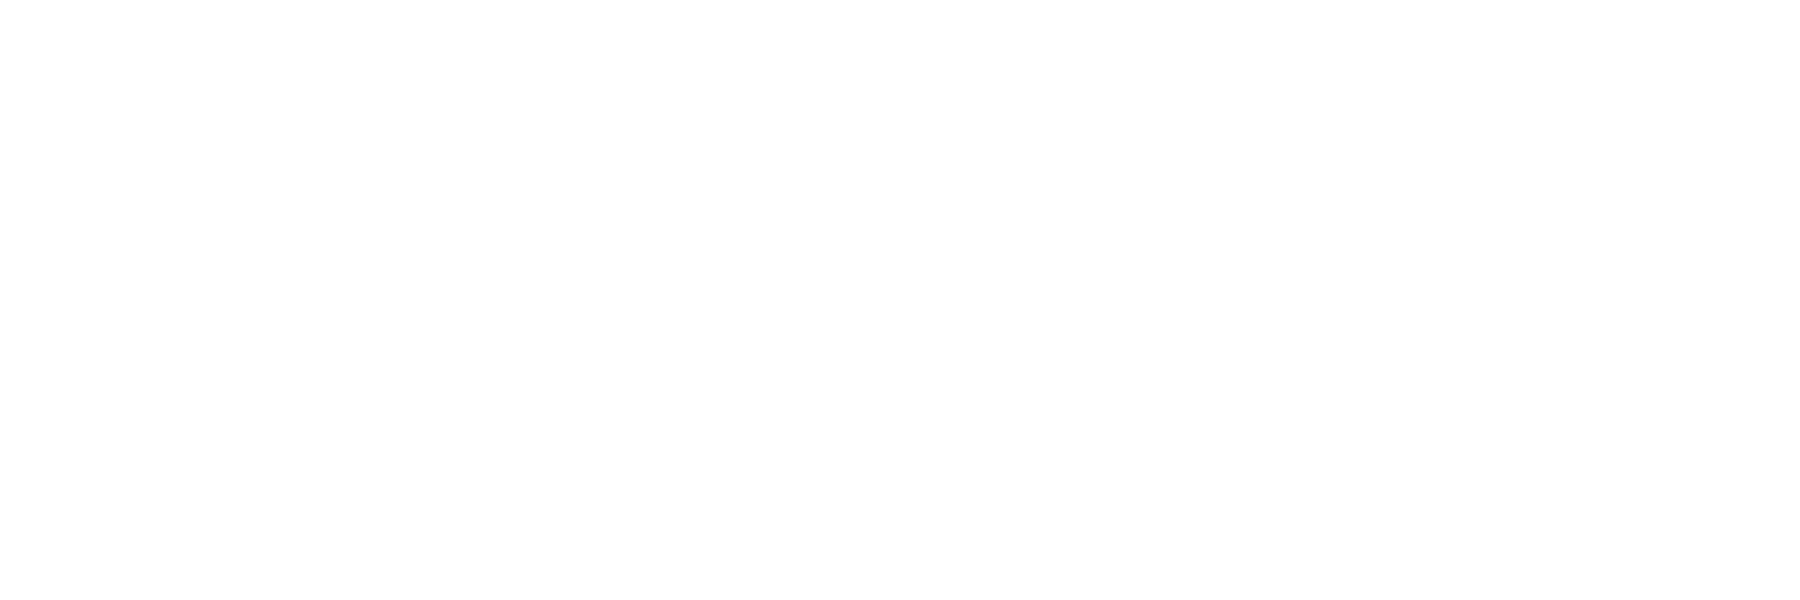

In [3]:
plots.show_sines(train_data, train_targets, skip=10)

We can easily implement RNN for single-step prediction in `keras`:

In [4]:
from tensorflow.keras.layers import LSTM, Dense

class RecurrentModel(keras.Model):
    
    def __init__(self):
        super(RecurrentModel, self).__init__()
        self.lstm = LSTM(
            units=20)  # LSTM output shape
        self.dense = Dense(
            units=1)  # We want to output one number as a prediction
        
    def call(self, x):     # (batch_size, time_steps, input_dim)
        x = self.lstm(x)   # (batch_suze, lstm_dim)
        x = self.dense(x)  # (batch_size, dense_dim)
        return x
    
model = RecurrentModel()

model.compile(
    optimizer='adam',
    loss='mean_squared_error')  # MSE is a good loss for regression tasks like this

model.fit(
    x=train_data,
    y=train_targets,
    epochs=50,
    batch_size=10,
    validation_data=test_dataset)

Train on 1000 samples, validate on 100 samples
Epoch 1/50
1000/1000 [==============================] - 11s 11ms/sample - loss: 0.3506 - val_loss: 0.2020
Epoch 2/50
1000/1000 [==============================] - 8s 8ms/sample - loss: 0.2598 - val_loss: 0.1670
Epoch 3/50
1000/1000 [==============================] - 7s 7ms/sample - loss: 0.1779 - val_loss: 0.1329
Epoch 4/50
1000/1000 [==============================] - 7s 7ms/sample - loss: 0.1063 - val_loss: 0.0590
Epoch 5/50
1000/1000 [==============================] - 7s 7ms/sample - loss: 0.0649 - val_loss: 0.0489
Epoch 6/50
1000/1000 [==============================] - 7s 7ms/sample - loss: 0.0494 - val_loss: 0.0304
Epoch 7/50
1000/1000 [==============================] - 7s 7ms/sample - loss: 0.0414 - val_loss: 0.0251
Epoch 8/50
1000/1000 [==============================] - 7s 7ms/sample - loss: 0.0330 - val_loss: 0.0330
Epoch 9/50
1000/1000 [==============================] - 7s 7ms/sample - loss: 0.0301 - val_loss: 0.0185
Epoch 10/50
100

KeyboardInterrupt: 

__Exercise 8.2:__ Shapes of `x` are described in the `call` function of `RecurrentModel`. What are the actual values of the described quantities? E.g. what is the value of `batch_suze` in this case?

## RNNs for Natural Language Processing

RNNs are often used for _natural language processing_ (NLP). Words are sequences of letters, sentences are sequences of words, documents are sequences of paragraphs. Both written and spoken language are sequential in nature. RNNs are appropriate choice for sequence processing. In addition, RNNs are also quite versatile, as we have seen before. Their different architectures can be used for different NLP tasks.

__Exercise 8.3:__ Can you name some NLP tasks for each basic RNN architecture (many to one, one to many, etc.) described above?

But, how should we feed text into neural models? The most common way is to feed the text word by word. Each word is represented by its `id` - a unique integer identifier. We get this `id` simply by constructing a vocabulary of all the words we have in our dataset.

We have some data ready for you:

In [5]:
dataset = data.load_pos_data('data/train')

print(f'Number of samples: {len(dataset)}')

for sample in dataset[:5]:
    print(sample.text)

Number of samples: 200
('Kde', 'tá', 'ľudská', 'duša', 'drieme', '?')
('Prečo', 'to', 'tu', 'píšem', '?')
('Prečo', 'je', 'dnešný', 'humor', 'suchý', '?')
('Aby', 'sa', 'ľudia', 'mohli', 'smiať', '.')
('Prečo', 'niesme', 'prirodzení', '?')


And we also constructed the vocabulary for you. It is simply a dictionary with words as keys and theirs `ids` as values:

In [6]:
vocabulary = data.load_vocabulary()

print(vocabulary)

{'<pad>': 0, 'Vtedy': 1, 'kategória': 2, 'Lee': 3, 'terénnych': 4, 'chuti': 5, 'pobyt': 6, 'Odkiaľ': 7, 'lístkami': 8, 'súťaž': 9, 'Strong': 10, 'Chvíľu': 11, 'vtedajší': 12, 'skalickom': 13, 'Víťaz': 14, 'Uvedomovali': 15, 'retrospektívnu': 16, 'televíznom': 17, 'inteligencie': 18, 'ohľady': 19, 'dělal': 20, 'dĺžku': 21, 'začali': 22, 'Asociácia': 23, 'úsmevom': 24, 'požiadavky': 25, 'plodom': 26, 'bánk': 27, 'funkciu': 28, 'Ethan': 29, 'pri': 30, 'nim': 31, 'Viera': 32, 'skalického': 33, 'ceremoniálu': 34, 'vyhrabala': 35, 'Dovtedy': 36, 'bola': 37, 'dostať': 38, 'premiéra': 39, 'stáť': 40, 'mačka': 41, 'profesor': 42, 'nerovností': 43, 'názvom': 44, 'odpísala': 45, 'vyjadrovali': 46, 'nezaujímavého': 47, 'svojho': 48, 'obchodom': 49, 'pohľadu': 50, 'úmorného': 51, 'Tom': 52, 'fotografiu': 53, 'zaoberal': 54, 'rómske': 55, 'Ostanem': 56, 'Samonafukovacie': 57, 'Ja': 58, 'prikrývky': 59, 'Internet': 60, 'myš': 61, '10': 62, 'Obyčajne': 63, 'určovala': 64, 'zmluvy': 65, 'ostatné': 66, 

With this vocabulary, we can easily transform any text into a list of ids:


In [7]:
sentence = dataset[0].text
ids = [vocabulary[word] for word in sentence]
print(sentence, ids)

('Kde', 'tá', 'ľudská', 'duša', 'drieme', '?') [1343, 408, 1690, 70, 1811, 1460]


Sentence is then simply a sequence of integers. We feed this sequence into neural networks via a so called _embedding layer_. For a vocabulary of size $V$, such layer contains an _embedding matrix_ $\mathbf{E}$ with $V$ rows. In this matrix, $i$-th row is a vector representation for word with `id == i`. When we have a vocabulary with 500 word, $\mathbf{E}$ will have 500 rows and in each row a vector representation for one word will be stored. The number of columns - how long are the word representations - is a hyperparameter. It is usually in the order of hundreds.

Below is how embedding layer for vocabulary with $V = 5$ and embedding size $3$ works on a sequence of integers $\mathbf{s}$:

$$
\mathbf{E} = \begin{vmatrix}
e_{11} & e_{12} & e_{13} \\
e_{21} & e_{22} & e_{23} \\
e_{31} & e_{32} & e_{33} \\
e_{41} & e_{42} & e_{43} \\
e_{51} & e_{52} & e_{53}
\end{vmatrix}
\quad
\mathbf{s} = \langle 1, 3, 5, 1 \rangle
\quad
emb_{\mathbf{E}}(\mathbf{s}) = \begin{vmatrix}
e_{11} & e_{12} & e_{13} \\
e_{31} & e_{32} & e_{33} \\
e_{51} & e_{52} & e_{53} \\
e_{11} & e_{12} & e_{13} \\
\end{vmatrix} \\
$$

The embedding layer is implemented in `keras`. The output from an embedding layer can then be directly fed into a recurrent layer. The code below shows an example of a simple LSTM-based text classificator:

```python
class TextClassificator(keras.Model):

    def __init__(self, vocab_size, embedding_size, lstm_units. num_classes):   
        super(TextClassificator, self).__init__()
        
        self.emb = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_size)
        
        self.lstm =LSTM(
            units=lstm_units)
        
        self.dense = Dense(
            units=num_classes,
            activation='softmax')

    def call(self, x):
        x = self.emb(x)
        x = self.lstm(x)
        x = self.dense(x)
        return x
```

__Exercise 8.4:__ What is the shape of `x` for each step of the `call` method? Check the code for sine wave prediction above for some hints.

### Pre-trained embeddings

Each row of $\mathbf{E}$ is a vector representationf for one word. It encodes the semantic information about the word. Because many NLP tasks need the same information, we can actually reuse the trained $\mathbf{E}$ in other models. This is a type of _transfer learning_. If we store the trained $\mathbf{E}$, we can then later simply initialize the embedding with this matrix in other models:

```python
from tensorflow.keras.initializers import Constant

matrix = np.array([...])  # 2D numpy array

self.emb = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_size,
    embeddings_initializer=Constant(matrix))
```

When we reuse pre-trained embeddings, we need to make sure that the vocabularies match, i.e. that the ids of the words are the same. If the model that trained the embeddings had the word _dog_ with `id == 1`, the model that uses the emebddings should also have `id == 1` for _dog_.

This technique of reusing embeddings is especially useful when we do not have much training data. The pre-trained embeddings provide information that can bootstrap the model. E.g. normally, if the model does not encounter the word _cat_ during the training, it does not know what to do with this word during the evaluation. However, with pre-trained embeddings, the model already saw similar words, such as _dog_. The model then can assume that the words should behave similarly.

Often we fix the values of pre-trained embeddings during the training. That means that the value of $\mathbf{E}$ is not updated by the training algorithm and it will stay the same throughout the whole training. Whether to train the pre-train embedding matrix is also a hyperparameter. It is usually not recommended to train the pre-trained embeddings, unless you have a relatively big dataset. You can control this behavior by using `trainable` parameter of `Embedding` layer:

```python
self.emb = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_size,
    embeddings_initializer=Constant(matrix),
    trainable=False)
```

#### Embedding libraries

There are multiple libraries used to generate word embeddings that you can use: `word2vec`, `GloVe`, `fastText`, and many others. They train the word representation on language modeling tasks. I would recommend using `fastText`, empirically it has a very good performance.

You can pre-train your own embeddings with these libraries by providing them a text corpus. Or even better, you can simply download the pre-trained representations that someone else already created, e.g. `fastText` has [published their representations for many languages](https://fasttext.cc/docs/en/crawl-vectors.html). The pre-trained embeddings are simply a file where in each row we have a word and its vector written. Check out the `/week_8/data/embeddings` file in the repository.

__Exercise 8.5:__ TensorBoard can also visualize word embeddings so we can explore them. Check out this [online demo](https://projector.tensorflow.org/) for a visualization of an English vocabulary. I would recommend using _T-SNE_ or _UMAP_ visualization aglorithms (you can pick them in the left menu). We have also prepared a visualization of a limited Slovak dictionary in your local [TensorBoard Projector tab](http://localhost:6006/#projector). There you can check various interesting relations between words, e.g. use the search function on the right to find `1999` word. You should see that it is in a cluster of calendar-related words.

__Exercise 8.6:__ Check out this online [demo of word2vec embeddings](http://turbomaze.github.io/word2vecjson/). You can use any English word (as long as it is in the demo vocabulary) as query and it should return a list of the most similar words according to the pre-trained embeddings. Try some words to see what are the results.

#### Vocabularies in practice

We operate with two vocabularies, a vocabulary of words in our dataset and a vocabulary of words for which we have pre-trained embeddings. These two usually do not overlap perfectly. We have two issues:

1. _Useless pre-trained embeddings._ We can have pre-trained representations for words that are not present in the training or testing data. We can simply discard embeddings like these during an experiment.
2. _Missing pre-trained embeddings._ We can have words in our data for which we do not have pre-trained embeddings. There are multiple strategies of handling words like these:

  - First, we should check for pre-trained embeddings for similar words. Maybe we need to lowecase the word or add/remove diacritics.
  - We can create a random vector for words like these.
  - We can discard such words and use a special `<unknown>` token instead of them. This token can simply have a zero vector as an embedding.

### Programming Assignment 8.7: Part-of-Speech Tagger [2 pts]

Part-of-speech tagging _(POS tagging)_ is a classical NLP task. We want to mark each word in a sentence with a correct POS tag. POS tags are grammatical categories of words, such as _verb_, _noun_, etc. The data for this task consist of sentences and their respective POS tags:

```
Kde     ADV
tá      DET
ľudská  ADJ
duša    NOUN
drieme  VERB
?       PUNCT
```

In this case we use the [Universal POS tagset](https://universaldependencies.org/u/pos/) designed to handle majority of natural languages. Check the link to see how are the tags defined. In this task, we are essentially trying to perform a classification for each word. We can solve this task with an RNN architecture:

1. We feed the network with word ids.
2. We use an embedding layer to project them into vector space.
3. We use _many to many_ RNN to process the vectors.
4. We use a softmax dense layer to make a prediction for each word.

__Exercise 8.8:__ Why do we need _many to many_ RNN?

Your task here is to program your own POS tagger. We have prepared two sets of data `data/train` for training and `data/test` for testing. You can use the data loader and vocabulary loader you have seen above. We also prepared a set of pre-trained embeddings in `data/embeddings`. In this case we have a well behaved vocabularies -- all the words from datasets have their embeddings and all the embeddings are used.

1. Prepare the data into a dataset that can be fed into a TensorFlow model. Both input data `x` and labels `y` should be an integer 2D matrix with `(num_samples, sentence_length)` shape. Each row is a sequence of ids for one sentence. Sentences can have different lengths - pad the shorter sequences with zeros. The `sentence_length` should be as long as the longest sentence in the dataset.


In [8]:
train = data.load_pos_data('data/train')
test = data.load_pos_data('data/test')
vocab = data.load_vocabulary()
pos_vocab = data.pos_vocabulary

import numpy as np
from week_8.backstage.data import *

## Hint
sample = train[0]
word_ids = [vocab[word] for word in sample.text]
tag_ids = [pos_vocab[tag] for tag in sample.labels]

print(sample.text, word_ids)
print(sample.labels, tag_ids)

train_x = [[vocab[w] for w in s.text] for s in train]
train_y = [[pos_vocab[w] for w in s.labels] for s in train]
test_x = [[vocab[w] for w in s.text] for s in test]
test_y = [[pos_vocab[w] for w in s.labels] for s in test]


train_x = keras.preprocessing.sequence.pad_sequences(train_x, padding='post')
train_y = keras.preprocessing.sequence.pad_sequences(train_y, padding='post')
test_x = keras.preprocessing.sequence.pad_sequences(test_x, padding='post')
test_y = keras.preprocessing.sequence.pad_sequences(test_y, padding='post')

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

('Kde', 'tá', 'ľudská', 'duša', 'drieme', '?') [1343, 408, 1690, 70, 1811, 1460]
('ADV', 'DET', 'ADJ', 'NOUN', 'VERB', 'PUNCT') [2, 5, 0, 7, 15, 12]
(200, 34) (200, 34)
(200, 36) (200, 36)



2. Implement the described architecture in `keras`. There are some tricky parts to it. First, you should _mask_ the padding you added. Check out the [keras tutorial about masking.](https://www.tensorflow.org/guide/keras/masking_and_padding). Second, you should use bi-directional LSTM. Luckily, `keras` has a `Bidirectional` wrapper. Third, by default the LSTM return only a last output (many to one), here we want the output for all the words (many to many). Check the documentation of LSTM layer.

3. If you want to use pre-trained embeddings, we have prepared the pre-trained fastText matrix $\mathbf{E}$ for you: `data.embedding_matrix(vocabulary)`. You can initialize your embedding layer with it.

4. Train the model. Compare the results with and without pre-trained embeddings. Compare the results with bi-directional LSTM and with one-directional LSTM. Compare the results when you train the pre-trained embeddings and when you do not train them. You should be able to get up to 94.5% validation accuracy with these experiments with the default hyperparameters provided in the code below.


In [39]:
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.initializers import Constant
from datetime import datetime

class POSTagger(keras.Model):

    def __init__(self):
        super(POSTagger, self).__init__()
        self.emb = Embedding(
            input_dim=len(vocab), 
            output_dim=300, 
            mask_zero=True,
            weights=[data.embedding_matrix(vocab)]
        )
        self.lstm = Bidirectional(LSTM(300, return_sequences=True, activation='softmax'))

    def call(self, inputs):
        x = self.emb(inputs)
        mask = self.emb.compute_mask(inputs)
        output = self.lstm(x, mask=mask)
        return output


model = POSTagger()

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])


logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
model.fit(
    x=train_x,
    y=train_y,
    batch_size=10,
    epochs=100,
    validation_data=(test_x, test_y),
    callbacks=[tensorboard_callback]
)


Train on 200 samples, validate on 200 samples
Epoch 1/100
200/200 [==============================] - 7s 37ms/sample - loss: 1.8117 - accuracy: 0.2594 - val_loss: 1.4470 - val_accuracy: 0.4391
Epoch 2/100
200/200 [==============================] - 3s 15ms/sample - loss: 1.7662 - accuracy: 0.7786 - val_loss: 1.4091 - val_accuracy: 0.5885
Epoch 3/100
200/200 [==============================] - 3s 13ms/sample - loss: 1.7070 - accuracy: 0.8885 - val_loss: 1.3575 - val_accuracy: 0.6179
Epoch 4/100
200/200 [==============================] - 3s 13ms/sample - loss: 1.6159 - accuracy: 0.8850 - val_loss: 1.2707 - val_accuracy: 0.5543
Epoch 5/100
200/200 [==============================] - 3s 13ms/sample - loss: 1.4519 - accuracy: 0.6204 - val_loss: 1.1481 - val_accuracy: 0.3293
Epoch 6/100
200/200 [==============================] - 3s 14ms/sample - loss: 1.2709 - accuracy: 0.3903 - val_loss: 1.0725 - val_accuracy: 0.3353
Epoch 7/100
200/200 [==============================] - 3s 15ms/sample - loss: 

KeyboardInterrupt: 

In [40]:
%tensorboard --logdir logs --bind_all

#### Data

The data come from [Slovenský Národný Korpus (Slovak National Corpus) dataset](https://github.com/UniversalDependencies/UD_Slovak-SNK). We used only a limited amount of 200 sentences for both training and testing set. The pre-trained embeddings come from the official [fastText repository](). The original embeddings have 2M words in them, here we provide only the embeddings for the words you need (~2000 words).

#### Submission

Submit the code that prepares the testing and training data and your model code as one `.py` file. Also submit the training logs (appropriately named, e.g. `pretrained_emb_bidirectional`). All the files should be zipped.

## Further Reading

- Chistopher Olah has nice blog posts about both [LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) and [word embeddings](https://colah.github.io/posts/2014-07-NLP-RNNs-Representations/).
- Chapter 10 from Deep Learning book by Ian Goodfellow et al. provides a great overview of RNNs.

## Correct Answers

__E 8.1:__ Many-to-one.

__E 8.2:__ `batch_size` is 10, as defined in `fit` method call. `time_steps` is 250, as defined during dataset creation. `input_dim` is 1, we only input one value each step. `lstm_dim` is 20, as defined during LSTM layer initialization. `dense_dim` is 1, as defined during Dense layer initialization. We always output one value - a target prediction.

__E 8.3:__
- _Many to one:_ All forms of text classification, such as sentiment analysis, hate-speech detection, spam detection, document classification. It can be also used for language modeling - predicting the next word in a sentence.
- _One to many:_ Various task generation tasks, such as image captioning.
- _Many to many:_ Word tagging tasks, such as part-of-speech tagging, named entity recognition, dependency parsing.
- _Sequence to sequence:_ Tasks, when we have a sequence both as input and output, e.g. machine translation, speech-to-text, text-to-speech, summarization.

__E 8.4:__
```python
def call(self, x):     # (batch_size, time_steps)
    x = self.emb(x)    # (batch_size, time_steps, embedding_size)
    x = self.lstm(x)   # (batch_size, lstm_units)
    x = self.dense(x)  # (batch_size, num_classes)
    return x
```

__E 8.8:__ Because we need an output for each word.